**Gerekli Kütüphanelerin Yüklenmesi**

In [12]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf
from PIL import Image

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Veri Seti Yükleme**

without_mask sınıfı image sayısı: 3828
without_mask sınıfı örnek image


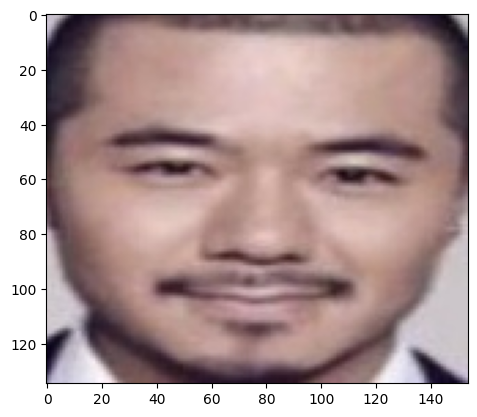

with_mask sınıfı image sayısı: 3725
with_mask sınıfı örnek image


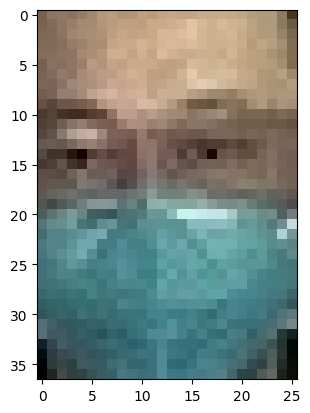

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Toplam Image Sayısı: 7553
Toplam Etiket Sayısı_1: 7553
Toplam Etiket Sayısı_2: 7553


In [3]:
# Verimizi Google Drive dizinimize yükledikten sonra sınıflarımızı (with_mask, without_mask) ve image sayılarımızı yazdırıyoruz.
# Image dosyalarımız farklı boyutlarda olduğu için Image Processing işlemi yaparak verimizi aynı boyuta ve renk koduna getiriyoruz.
# Derin öğrenme modelleri için verideki resimlerin boyutlarını sabit bir boyuta ölçeklendirmek gereklidir.
# DanseNet121 için genellikle kullanılan değer olarak boyutu 128*128 olarak renk kanalını 'RGB' olarak güncelliyoruz.
data_path = '/content/drive/MyDrive/UskudarUni/data/fmd'
data_image = []

for class_path in os.listdir(data_path):
  class_folder_path = os.path.join(data_path, class_path)

  print(f"{class_path} sınıfı image sayısı: {len(os.listdir(class_folder_path))}")
  print(f"{class_path} sınıfı örnek image")

  if class_path == 'with_mask':
    with_mask_label_2 = [[1,0]] * len(os.listdir(class_folder_path))
    with_mask_label_1 = [1] * len(os.listdir(class_folder_path))
    img=mimg.imread(class_folder_path + '/with_mask_1088.jpg')
    imgplot=plt.imshow(img)
    plt.show()
  else:
    without_mask_label_2 = [[0,1]] * len(os.listdir(class_folder_path))
    without_mask_label_1 = [0] * len(os.listdir(class_folder_path))
    img=mimg.imread(class_folder_path + '/without_mask_10.jpg')
    imgplot=plt.imshow(img)
    plt.show()

  for img_file in os.listdir(class_folder_path):
    # print(class_folder_path +'/'+img_file)
    image = Image.open(class_folder_path + '/' + img_file)
    image = image.resize((128,128))
    image = image.convert('RGB')
    image = np.array(image)
    data_image.append(image)

#Farklı modeller deneyebilmek için tek ve 2 boyutlu etiketten oluşan veri seti oluşturuyoruz.
data_label_1 = with_mask_label_1 + without_mask_label_1
data_label_2 = with_mask_label_2 + without_mask_label_2

print(f"Toplam Image Sayısı: {len(data_image)}")
print(f"Toplam Etiket Sayısı_1: {len(data_label_1)}")
print(f"Toplam Etiket Sayısı_2: {len(data_label_2)}")

In [10]:
X1=np.array(data_image)
Y1=np.array(data_label_1)

print('X1 Boyutu:', X1.shape)
print('Y1 Boyutu:', Y1.shape)
print("---------------")
X2=np.array(data_image)
Y2=np.array(data_label_2)

print('X2 Boyutu:', X2.shape)
print('Y2 Boyutu:', Y2.shape)

X1 Boyutu: (7553, 128, 128, 3)
Y1 Boyutu: (7553,)
---------------
X2 Boyutu: (7553, 128, 128, 3)
Y2 Boyutu: (7553, 2)


**Veri Setinin Eğitim/Validasyon ve Test Olarak Ayrılması**

In [11]:
# Verileri Eğitim, Test ve Validasyon olarak ayırıyoruz.
# Verimizi %80 Eğitim, % 20 Test olarak ayırıyoruz.
X1_temp, X1_test, Y1_temp, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)
X2_temp, X2_test, Y2_temp, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

# Eğitim verimizi %80 Eğitim, % 20 Validasyon olarak ayırıyoruz.
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X1_temp, Y1_temp, test_size=0.2, random_state=42)
X2_train, X2_val, Y2_train, Y2_val = train_test_split(X2_temp, Y2_temp, test_size=0.2, random_state=42)

# Sonuçları yazdırma
print("Eğitim boyutu:", len(X1_train))
print("Validasyon boyutu:", len(X1_val))
print("Test boyutu:", len(X1_test))
print("---------------")
print("Eğitim boyutu:", len(X2_train))
print("Validasyon boyutu:", len(X2_val))
print("Test boyutu:", len(X2_test))

Eğitim boyutu: 4833
Validasyon boyutu: 1209
Test boyutu: 1511
---------------
Eğitim boyutu: 4833
Validasyon boyutu: 1209
Test boyutu: 1511


**Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması, Modelin Eğitilmesi, Test Verisi İle Tahmin (Prediction) ve Sonuç Analizi**

In [24]:
# DenseNet121 modelini oluşturuyoruz. Modelin ağırlığı ImageNet veri seti üzerinde önceden eğitilmiştir. None seçiyor olsaydık model sıfırdan başlayacaktı.
# input_top özelliğini modelin tepe katmanı içermemesi için False seçeriz.
# Modelin giriş boyutunu daha önce Image Processing yaptığımızda belittiğimiz değerler olan (128, 128, 3) seçeriz.

base_modelDense = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Önceden eğitilmiş modelin katmanların dondurarak modeldeki her bir katmanın ağırlıklarının güncellenmesini engelliyoruz.
# Yani bu katmanlar model eğitilirken "donmuş" halde kalır ve geri yayılım (backpropagation) sırasında bu katmanların ağırlıkları değiştirilmez.
# Dondurulan katmanlar eğitilmediği için eğitim süresi kısaltmış ve kaynak tüketimi azaltmış oluyoruz.
# Eğitimden sonra gerekirse dondurulan katmanları serbest bırakabilir ve ince ayar (fine-tuning) yapabiliriz.

for layer in base_modelDense.layers:
    layer.trainable = False

# Özelleştirilmiş bir tepe katmanı (classification head) ekliyoruz. Özellikle sınıflandırma problemleri için yaygın olan bu mimariyi kullanıyoruz.
# Modelin son katmanından gelen özellik haritalarını (feature maps) ekliyoruz. 2D özellik haritalarını sıkıştırmak ve çıkış boyutunu küçültmek için GlobalAveragePooling2D kullanıyoruz.
# Dropout katmanındaki nöronları %50 oranında rastgele devre dışı bırakıyoruz. Overfittingi azaltır ve genelleştirme yeteneğini arttırmış oluyoruz.
# Modelin daha yüksek seviyeli özellikleri öğrenmesine yardımcı olmak için 128 nörondan oluşan ve ReLu aktivasyon fonksiyonunu kullanan dense katman ekleriz.
# 64 nörondan oluşan ve ReLu aktivasyon fonksiyonunu kullanan dense katman ekleriz.
# Son 2 sınıf için tahminler yapan ve olasılık skorları üreten softmax aktivasyonunu kullanan çıkış katmanını ekliyoruz.
x = base_modelDense.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictionsDense = Dense(2, activation='softmax')(x)

# Modelin giriş ve çıkışlarını belirleyerek oluşturuyoruz.
modelDense = Model(inputs=base_modelDense.input, outputs=predictionsDense)

# Derin öğrenme için Stochastic Gradient Descent (SGD) optimizasyon algoritmasını tanımlıyoruz.
# Ağırlıkların güncellenme hızını daha küçük öğrenmesi ve stabil bir eğitim sağlaması için 0,0001 olarak belirleriz.
# Momentum ile ağırlık güncellemelerinde geçmiş adımları dikkate alarak optimizasyon sürecini hızlandırırız.
# Momentum kullanabilmek için SGD kullanıyoruz.
model_optimizerDense = SGD(learning_rate=0.0001, momentum=0.9)

# Modeli derlemek için birden fazla sınıfı tahmin etmede kullanılan kayıp fonksiyonunu kullanıyoruz. İkili sınıflandırma problemleri için binary_crossentropy kullanabilirdik.
# categorical_crossentropy kullanarak modelin tahminleri ile gerçek etiketler arasındaki farkı hesaplar ve daha doğru tahminler yapacak şekilde ağırlıkları günceller. Çıkış katmanında genellikle softmax aktivasyon fonksiyonu ile birlikte kullanılır.
# Eğitim ve değerlendirme sırasında modelin performansını ölçmek için accuracy metriğini belirleriz.
modelDense.compile(optimizer=model_optimizerDense, loss='categorical_crossentropy', metrics=['accuracy'])

# Modeliin mimarisi hakkında özet bilgiyi gösteriyoruz.
# Modelde oluşturduğumuz katmanları, çıkış tensörünün boyutunu ve öğrenilebilir parametrelerin toplamn sayısını görüyoruz.
# Eğitim sırasında güncellneebilir parametreler Trainable params ile önceden eğitilmiş ağırlıklar Non-trainable params olarak gözükmektedir.
modelDense.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 134, 134, 3)    │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,177,090 (27.38 MB)

 Trainable params: 139,586 (545.26 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [25]:
# ImageDataGenerator kullanarak veri arttırma işlemini gerçekleştiriyoruz. Veri artırma işlemleriyle modelin daha çeşitli veriler üzerinde eğitilmesini sağlıyoruz.
# Bu sayede modelin daha genel bir şekilde öğrenmesine yardımcı olur ve overfitting riskini azaltır.
datagenDense = ImageDataGenerator(
    rescale=1./255,  # Pikcel değerlerini 0 ile 1 arasında normalize ediyoruz.
    rotation_range=10,  # Resimleri 10 derece kadar döndürür.
    width_shift_range=0.1,  # Resimleri yatay eksende %10 kadar kaydırır.
    height_shift_range=0.1,  # Resimleri dikey eksende %10 kadar kaydırır.
    shear_range=0.1,  # Resimlerin üzerinde kesme uygulanır.
    zoom_range=0.1,  # Resimler %10 oranında yakınlaştırır veya uzaklaştırır.
    horizontal_flip=True,  # Resimleri yatay olarak rastgele çevirir.
    fill_mode='nearest'  # Veri arttırma sırasında dışarı taşan pikselleri doldurur.
)

# Veri arttırma işlemini eğitim verileri üzerinde uyguluyoruz.
datagenDense.fit(X2_train)

# EarlyStopping ile model eğitimi sırasında erken durdurma mekanizmasını tanımlıyoruz.
# Modelin fazla öğrenmesini (overfitting) önlemek ve gereksiz yere uzun süren eğitim süreçlerini durdurmak için kullanırız.
# Eğitim sırasında izlenecek metrik olarak doğrulama veri kümesi üzerindeki kayıp değer olan val_loss seçiyoruz.
# Eğitim sırasında belirlediğimiz metriğin 25 ardışık epoch boyunca iyileşmemesi durumunda eğitim durdurmak için patience 25 belirliyoruz.
# Model doğrulama kaybı açısından en iyi performansı gösterdiği zamandaki ağırlıklara geri yüklemesi için restore_best_weights özelliğini True seçeriz.
early_stoppingDense = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# ReduceLROnPlateau ile modelin öğrenme oranını (learning rate) dinamik olarak ayarlanmasını sağlarız.
# Doğrulama kaybı gibi bir metrik belirli bir süre boyunca iyileşmediğinde öğrenme oranını azaltır ve daha verimli bir eğitim sağlar.
# Eğitim sırasında izlenecek metrik olarak doğrulama veri kümesi üzerindeki kayıp değer olan val_loss seçiyoruz.
# Öğrenme oranının azaltılacağı faktör olarak 0.1 seçiyoruz. 5 epoch boyunca iyileşme görülmezse öğrenme oranı azalatılır.
# Öğrenme oranının inebileceği min değer olarak 0,000001 veriyoruz.
reduce_lrDense = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Arttırılmış eğitim verileri ile model her adımda 32 görüntü işleyecek şekilde modeli eğitmeye başlıyoruz.
# Modelin 100 epoch çalışmasını sağlarız. Doğrulama veri seti ile eğitim sırasında modelin genelleme yeteneğini kontrol ediyoruz.
historyDense = modelDense.fit(
    datagenDense.flow(X2_train, Y2_train, batch_size=32),
    epochs=100,
    validation_data=(X2_val, Y2_val),
    callbacks=[early_stoppingDense, reduce_lrDense]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 217ms/step - accuracy: 0.6046 - loss: 0.7431 - val_accuracy: 0.5674 - val_loss: 1.3201 - learning_rate: 1.0000e-04
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.8655 - loss: 0.3213 - val_accuracy: 0.5790 - val_loss: 1.3606 - learning_rate: 1.0000e-04
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.8958 - loss: 0.2608 - val_accuracy: 0.5897 - val_loss: 1.2169 - learning_rate: 1.0000e-04
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9174 - loss: 0.2232 - val_accuracy: 0.5914 - val_loss: 1.2587 - learning_rate: 1.0000e-04
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9189 - loss: 0.2180 - val_accuracy: 0.6063 - val_loss: 1.2299 - learning_rate: 1.0000e-04
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.9260 - loss: 0.2007 - val_accuracy: 0.6129 - val_loss: 1.1802 - learning_rate: 1.0000e-04
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/s

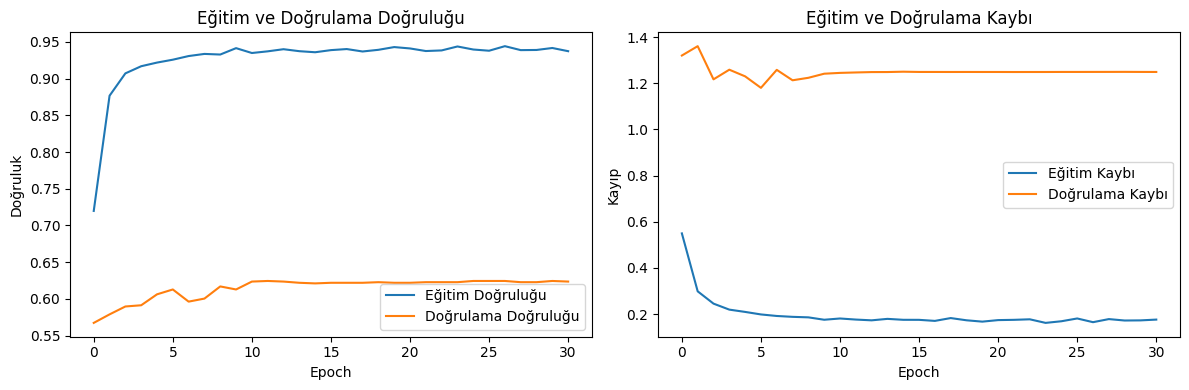

In [26]:
# Model eğitim doğruluğu (accuracy) %94 civarına ulaşmış oldukça yüksektir. Fakat Doğrulama Doğruluğu (val_accuracy) %62-63 civarında olup artış göstermemiştir. Doğrulama setinde genelleştirme yapamadığını ve overfitting yaptığını gösteriyor.
# Doğrulama kaybıda (val_loss) belirli bir yükseklikten başlamış ve belirli bir seviyede takılmıştır. Bu durum performansını optimize edemediğini gösteriyor.
# Öğrenme oranı (learning_rate) sürekli düşmüş ve min learning rate oranına ulaşmıştır.

# Eğitim ve Validasyon (Doğrulama) doğruluğu grafiğini çizdiririz.
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyDense.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(historyDense.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(historyDense.history['loss'], label='Eğitim Kaybı')
plt.plot(historyDense.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

In [33]:
# Dropout katmanları ekleyerek modelin genelleme kapasitesini artırmaya çalışıyoruz.
x = base_modelDense.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # <-- Dropout Eklendi
x = Dense(64, activation='relu')(x)
predictionsDense = Dense(2, activation='softmax')(x)

modelDense = Model(inputs=base_modelDense.input, outputs=predictionsDense)

model_optimizerDense = SGD(learning_rate=0.0001, momentum=0.9)

modelDense.compile(optimizer=model_optimizerDense, loss='categorical_crossentropy', metrics=['accuracy'])

modelDense.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 134, 134, 3)    │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,177,090 (27.38 MB)

 Trainable params: 139,586 (545.26 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [34]:
# Dropout eklenmiş modelin 100 epoch çalışmasını başlatıyoruz.
historyDense = modelDense.fit(
    datagenDense.flow(X2_train, Y2_train, batch_size=32),
    epochs=100,
    validation_data=(X2_val, Y2_val),
    callbacks=[early_stoppingDense, reduce_lrDense]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - accuracy: 0.6146 - loss: 0.8855 - val_accuracy: 0.5318 - val_loss: 1.6540 - learning_rate: 1.0000e-04
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.8083 - loss: 0.4423 - val_accuracy: 0.5492 - val_loss: 1.6558 - learning_rate: 1.0000e-04
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.8649 - loss: 0.3216 - val_accuracy: 0.5682 - val_loss: 1.7086 - learning_rate: 1.0000e-04
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.8840 - loss: 0.2923 - val_accuracy: 0.5699 - val_loss: 1.7802 - learning_rate: 1.0000e-04
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.8972 - loss: 0.2708 - val_accuracy: 0.5749 - val_loss: 1.8665 - learning_rate: 1.0000e-04
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.8918 - loss: 0.2568 - val_accuracy: 0.5724 - val_loss: 1.8579 - learning_rate: 1.0000e-04
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/s

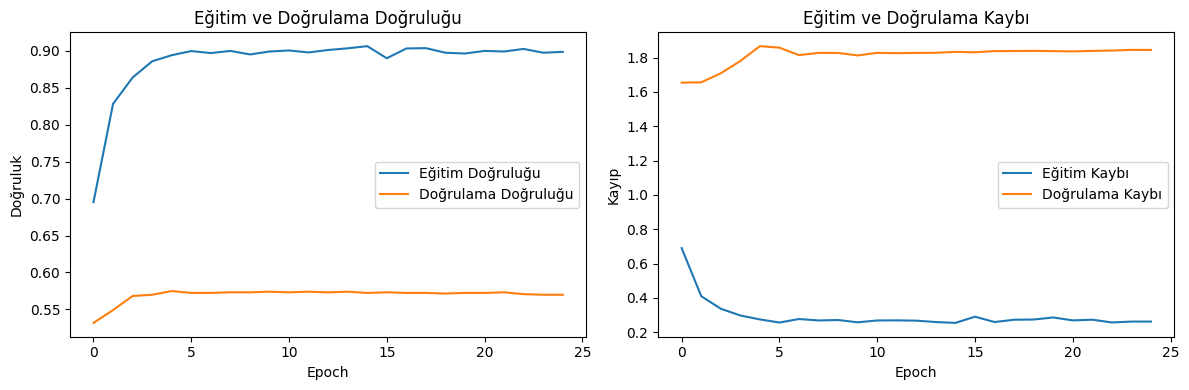

In [35]:
# Model eğitim doğruluğu (accuracy) %90 civarına ulaşmış önceki modele göre gerilemiştir. Doğrulama Doğruluğu (val_accuracy) %57-58 civarında olup artış göstermemiştir. Eğitim doğruluğu ve doğrulama doğruluğu arasındaki fark overfitting işareti olabilir.
# Doğrulama kaybıda (val_loss) belirli bir yükseklikten başlamış ve ilerleyen epochlarda düşüş göstermemiştir. Bu modelin genelleme yapmadığını ve yine overfitting yaşadığını gösteriyor.
# Öğrenme oranı (learning_rate) sürekli düşmüş ve min learning rate oranına ulaşmıştır.

# Eğitim ve Validasyon (Doğrulama) doğruluğu grafiğini çizdiririz.
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyDense.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(historyDense.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(historyDense.history['loss'], label='Eğitim Kaybı')
plt.plot(historyDense.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

In [44]:
# Aynı parametreler ile MobileNetV1 modelini oluşturuyoruz.
base_modelMNet = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_modelMNet.layers:
    layer.trainable = False

x = base_modelMNet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictionsMNet = Dense(2, activation='softmax')(x)

modelMNet = Model(inputs=base_modelMNet.input, outputs=predictionsMNet)

modelMNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelMNet.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,368,450 (12.85 MB)

 Trainable params: 139,586 (545.26 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [45]:
datagenMNet = ImageDataGenerator(
    rescale=1./255,  # Pikcel değerlerini 0 ile 1 arasında normalize ediyoruz.
    rotation_range=10,  # Resimleri 10 derece kadar döndürür.
    width_shift_range=0.1,  # Resimleri yatay eksende %10 kadar kaydırır.
    height_shift_range=0.1,  # Resimleri dikey eksende %10 kadar kaydırır.
    shear_range=0.1,  # Resimlerin üzerinde kesme uygulanır.
    zoom_range=0.1,  # Resimler %10 oranında yakınlaştırır veya uzaklaştırır.
    horizontal_flip=True,  # Resimleri yatay olarak rastgele çevirir.
    fill_mode='nearest'  # Veri arttırma sırasında dışarı taşan pikselleri doldurur.
)

datagenMNet.fit(X2_train)

early_stoppingMNet = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

reduce_lrMNet = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

historyMNet = modelMNet.fit(
    datagenMNet.flow(X2_train, Y2_train, batch_size=32),
    epochs=100,
    validation_data=(X2_val, Y2_val),
    callbacks=[early_stoppingMNet, reduce_lrMNet]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - accuracy: 0.8798 - loss: 0.2808 - val_accuracy: 0.5128 - val_loss: 1.8150 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9596 - loss: 0.1249 - val_accuracy: 0.5153 - val_loss: 2.2087 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9652 - loss: 0.1206 - val_accuracy: 0.5641 - val_loss: 1.0478 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9624 - loss: 0.1152 - val_accuracy: 0.5186 - val_loss: 1.5498 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9764 - loss: 0.0954 - val_accuracy: 0.5641 - val_loss: 0.9984 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9729 - loss: 0.0877 - val_accuracy: 0.5715 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9765 -

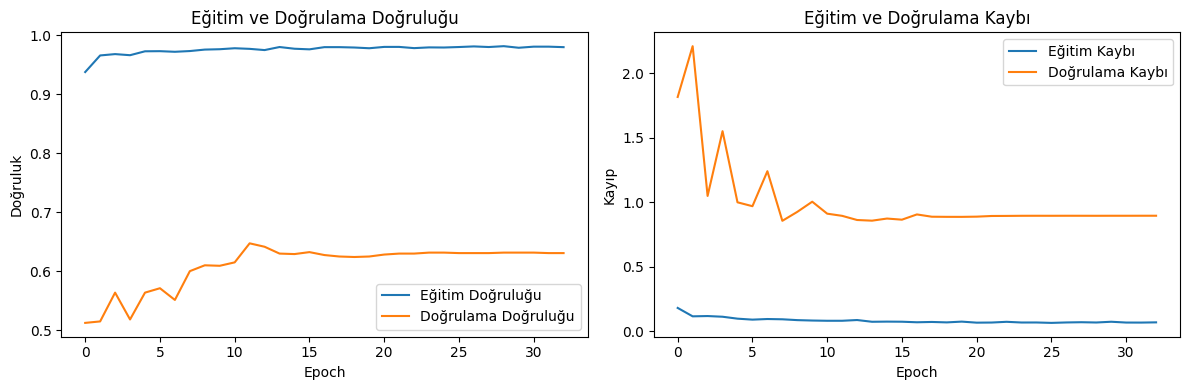

In [46]:
# Eğitim ve Validasyon (Doğrulama) doğruluğu grafiğini çizdiririz.
# Eğitim doğruluğu (accuracy) oldukça yüksek %98 seviyesine ulaşmıştır. Model overfitting olabileğeini gösteriyor.
# Doğrulama doğruluğu (val_accuracy) %63 civarında kadar yükselmiş sonra hiç artış göstermemiş. Modelin eğitim doğruluğu ve doğrulama doğruluğu arasındaki fark oldukça büyük. Bu durum modelin genellme problemi yaşadığını gösteriyor.
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyMNet.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(historyMNet.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(historyMNet.history['loss'], label='Eğitim Kaybı')
plt.plot(historyMNet.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

In [47]:
# Aynı parametreler ile MobileNetV1 modelini oluşturuyoruz.
base_modelMNet = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Modelde MobileNetV1 modelinin son 50 katmanını eğitilebilir hale getiriyoruz. Ağırlıklarının güncellenmesine izin veriyoruz.
for layer in base_modelMNet.layers[-50:]:
    layer.trainable = True

x = base_modelMNet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictionsMNet = Dense(2, activation='softmax')(x)

modelMNet = Model(inputs=base_modelMNet.input, outputs=predictionsMNet)

modelMNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelMNet.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,368,450 (12.85 MB)

 Trainable params: 3,346,562 (12.77 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [48]:
datagenMNet = ImageDataGenerator(
    rescale=1./255,  # Pikcel değerlerini 0 ile 1 arasında normalize ediyoruz.
    rotation_range=10,  # Resimleri 10 derece kadar döndürür.
    width_shift_range=0.1,  # Resimleri yatay eksende %10 kadar kaydırır.
    height_shift_range=0.1,  # Resimleri dikey eksende %10 kadar kaydırır.
    shear_range=0.1,  # Resimlerin üzerinde kesme uygulanır.
    zoom_range=0.1,  # Resimler %10 oranında yakınlaştırır veya uzaklaştırır.
    horizontal_flip=True,  # Resimleri yatay olarak rastgele çevirir.
    fill_mode='nearest'  # Veri arttırma sırasında dışarı taşan pikselleri doldurur.
)

datagenMNet.fit(X2_train)

early_stoppingMNet = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

reduce_lrMNet = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

historyMNet = modelMNet.fit(
    datagenMNet.flow(X2_train, Y2_train, batch_size=32),
    epochs=100,
    validation_data=(X2_val, Y2_val),
    callbacks=[early_stoppingMNet, reduce_lrMNet]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 189ms/step - accuracy: 0.9079 - loss: 0.2438 - val_accuracy: 0.5914 - val_loss: 0.7593 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9659 - loss: 0.1208 - val_accuracy: 0.5476 - val_loss: 0.8096 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9752 - loss: 0.1048 - val_accuracy: 0.8205 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9775 - loss: 0.0953 - val_accuracy: 0.7279 - val_loss: 0.5222 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9838 - loss: 0.0718 - val_accuracy: 0.7031 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9779 - loss: 0.0800 - val_accuracy: 0.6716 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9741 -

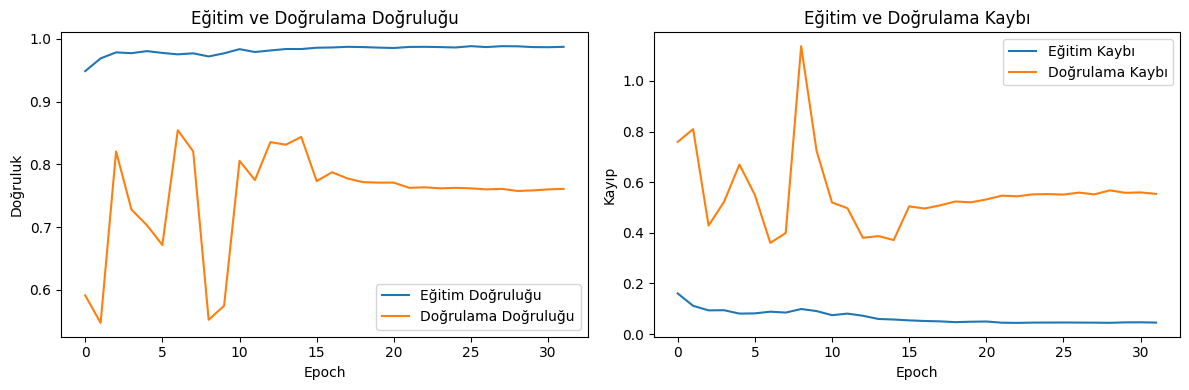

In [65]:
# Eğitim ve Validasyon (Doğrulama) doğruluğu grafiğini çizdiririz.
# Son 50 katmanı eğitilebilir hale getirdikten sonra eğitim doğruluğu (accuracy) oldukça yüksek %98-99 seviyesine ulaşmıştır. Eğitim kaybı oldukça düşüktür. Buda modelin eğitim verisinde oldukça iyi performans sergilediğini göstermektedir.
# Doğrulama doğruluğu (val_accuracy) başlangıçta artış göstermiş bir süre sonra sabit kalmıştır. Fakat doğrulama doğruluğu önceki sonuçlara göre önemli ölçüde artmış bazı epchlarda %85 aşmış.
# Modelin doğrulama doğruluğu yüksek doğruluğa ulaştıktan sonra düşüşe geçmiş overfitting olabileceğini göstermektedir.
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyMNet.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(historyMNet.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(historyMNet.history['loss'], label='Eğitim Kaybı')
plt.plot(historyMNet.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

In [67]:
# Test veri seti üzerinde tahmin yapıyoruz.
predictions = modelMNet.predict(X2_test)

predicted_labels = np.argmax(predictions, axis=1)

loss, accuracy = modelMNet.evaluate(X2_test, Y2_test)
print(f"Test Kayıp (Loss): {loss}")
print(f"Test Doğruluk (Accuracy): {accuracy}")

# 10 kayıt üzerinde tahminler ve doğrulukları gösteriyoruz.
print("ilk 10 Tahmin (Predictions):", predicted_labels[:10])
print("ilk 10 Doğru Etiket (True Labels):", np.argmax(Y2_test, axis=1)[:10])

# Model test verisini %85 doğru sınıflandırmıştır. İyi Performans göstermiştir.Eğitimin doğrulukla sonuçlandığını ve kayıp fonksiyonunun optimize edildiğini gözükmektedir.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8474 - loss: 0.3937
Test Loss: 0.39739498496055603
Test Accuracy: 0.849768340587616
First 10 Predictions: [0 0 0 0 1 1 0 1 0 1]
First 10 True Labels: [0 0 0 0 0 1 0 1 0 1]


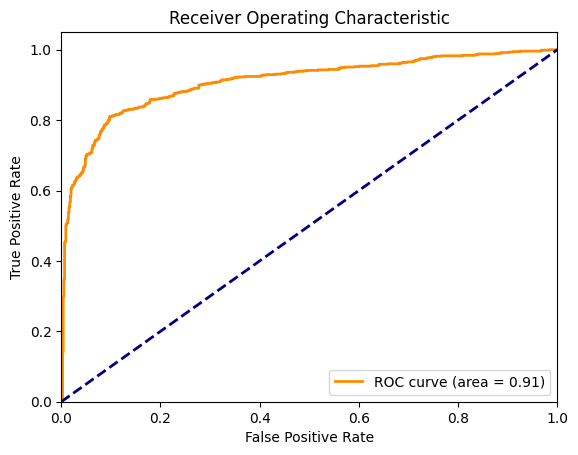

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y2_pred_prob = predictions[:, 1]

y2_true = np.argmax(Y2_test, axis=1)

fpr, tpr, thresholds = roc_curve(y2_true, y2_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC Eğrisini Çizdiriyoruz.
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Sınıflandırma modelinin performansını ölçmek için kullanılan ROC Eğrisi grafiğinde eğrinin sol üst köşeye yakın olması modelin iyi bir performansa sahip olduğunu ifade eder. Dodelin doğru pozitif oranını (TPR) yüksek tutarken yanlış pozitif oranını (FPR) düşük tuttuğunu gösteriyor.
# ROC eğrisinin altındaki alanı ifade eden ve modelin genel performansını özetleyen AUC değeri 0,91 olduğu için modelin pozitif ve negatif sınıfları ayırt etme yeteneği oldukça güçlüdür.
# ROC eğrisi ve AUC değeri modelin oldukça başarılı bir sınıflandırma performansına sahip olduğunu göstermektedir.

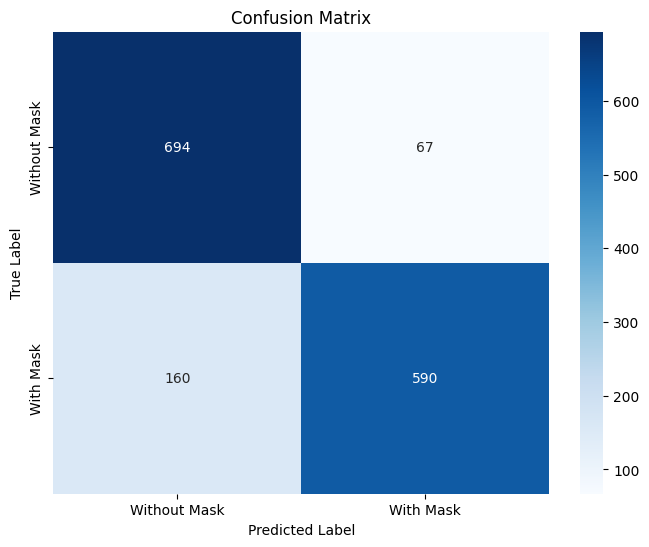

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix oluşturuyoruz.
cm = confusion_matrix(np.argmax(Y2_test, axis=1), predicted_labels)

# Confusion matrix çizdiriyoruz.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Without Mask', 'With Mask'],
            yticklabels=['Without Mask', 'With Mask'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# True negatives (694) değeri oldukça yüksek olduğu gözükmektedir.
# Modelin genel doğruluk oranı (%84.9) oldukça iyi, ancak özellikle "With Mask" sınıfında duyarlılık (recall) oranı artırılabilir.

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y2_true = np.argmax(Y2_test, axis=1)
y2_pred = predicted_labels

# Aşağıdaki performans metrikleri hesaplanır.
accuracy = accuracy_score(y2_true, y2_pred)
precision = precision_score(y2_true, y2_pred)
recall = recall_score(y2_true, y2_pred)
f1 = f1_score(y2_true, y2_pred)
tn, fp, fn, tp = confusion_matrix(y2_true, y2_pred).ravel()
specificity = tn / (tn+fp)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1-score: {f1}")

# Doğruluk (Accuracy) modelin genel doğruluğu yani Doğru tahmin oranı yaklaşık %85'tir.
# Precision (Kesinlik) oranının yüksek olması modelin "With Mask" tahminlerini büyük ölçüde doğru yaptığını gösteriyor. Yanlış pozitif (FP) oranı düşüktür.
# Recall (Duyarlılık) oranı precision (kesinlik) kadar yüksek değil. Modelin bazı maskeli bireyleri tespit etmekte zorlandığını (yanlış negatiflerin yüksek olduğunu) gösterir.
# Specificity (Özgüllük) yani model "Without Mask" sınıfını doğru tahmin etme oranı çok başarılıdır. Bu durum yanlış pozitiflerin (FP) az olduğunu gösterir.
# F1-Score modelin hem duyarlılık (recall) hem de kesinlik (precision) açısından dengeli bir performansa sahip olduğunu gösteriyor.

Accuracy: 0.8497683653209794
Precision: 0.898021308980213
Recall: 0.7866666666666666
Specificity: 0.911957950065703
F1-score: 0.8386638237384506


In [76]:
# Tek boyutlu etiket olan veri setimizi DenseNet121 modeli ile sigmoid olarak tek çıkışlı olarak oluşturuyoruz.

base_modelDenseS = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_modelMNet.layers:
    layer.trainable = False

x = base_modelDenseS.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictionsDenseS = Dense(1, activation='sigmoid')(x)

modelDenseS = Model(inputs=base_modelDenseS.input, outputs=predictionsDenseS)

model_optimizerDenseS = SGD(learning_rate=0.0001, momentum=0.9)

modelDenseS.compile(optimizer=model_optimizerDenseS, loss='binary_crossentropy', metrics=['accuracy'])

modelDenseS.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_12         │ (None, 134, 134, 3)    │              0 │ input_layer_23[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d_12[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_13         │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ zero_padding2d_13[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,177,025 (27.38 MB)

 Trainable params: 7,093,377 (27.06 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [77]:
datagenDenseS = ImageDataGenerator(
    rescale=1./255,  # Pikcel değerlerini 0 ile 1 arasında normalize ediyoruz.
    rotation_range=10,  # Resimleri 10 derece kadar döndürür.
    width_shift_range=0.1,  # Resimleri yatay eksende %10 kadar kaydırır.
    height_shift_range=0.1,  # Resimleri dikey eksende %10 kadar kaydırır.
    shear_range=0.1,  # Resimlerin üzerinde kesme uygulanır.
    zoom_range=0.1,  # Resimler %10 oranında yakınlaştırır veya uzaklaştırır.
    horizontal_flip=True,  # Resimleri yatay olarak rastgele çevirir.
    fill_mode='nearest'  # Veri arttırma sırasında dışarı taşan pikselleri doldurur.
)

datagenDenseS.fit(X1_train)

early_stoppingDenseS = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

reduce_lrDenseS = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = modelDenseS.fit(
    datagenDenseS.flow(X1_train, Y1_train, batch_size=32),
    epochs=100,
    validation_data=(X1_val, Y1_val),
    callbacks=[early_stoppingDenseS, reduce_lrDenseS]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 155s 448ms/step - accuracy: 0.6012 - loss: 0.6973 - val_accuracy: 0.5037 - val_loss: 7.8991 - learning_rate: 1.0000e-04
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.8126 - loss: 0.4168 - val_accuracy: 0.4698 - val_loss: 18.0741 - learning_rate: 1.0000e-04
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9142 - loss: 0.2588 - val_accuracy: 0.4756 - val_loss: 26.4129 - learning_rate: 1.0000e-04
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.9390 - loss: 0.1989 - val_accuracy: 0.4715 - val_loss: 20.7611 - learning_rate: 1.0000e-04
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.9487 - loss: 0.1611 - val_accuracy: 0.4367 - val_loss: 17.9728 - learning_rate: 1.0000e-04
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.9609 - loss: 0.1419 - val_accuracy: 0.4500 - val_loss: 24.1628 - learning_rate: 1.0000e-04
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 1

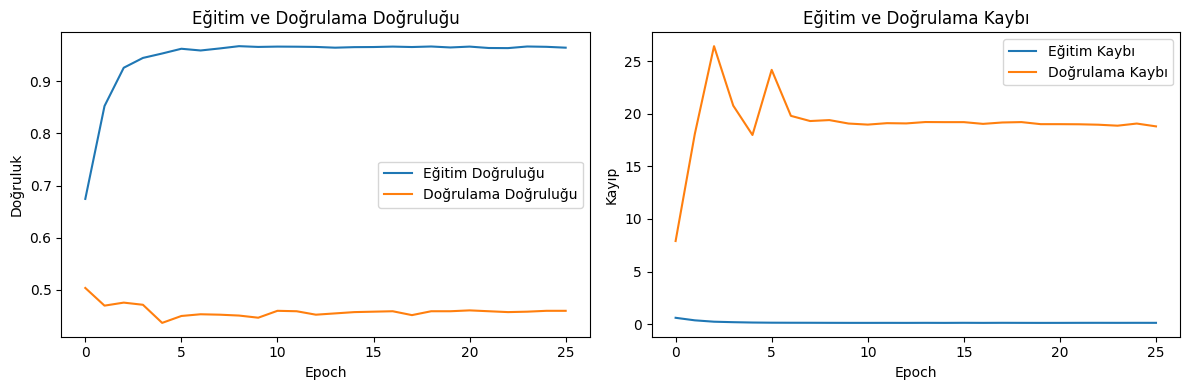

In [78]:
# Eğitim ve Validasyon (Doğrulama) doğruluğu grafiğini çizdiririz.
# Tek boyutlu etiket verisi ile oluşturulan model eğitim doğruluğu (accuracy) %96-97 seviyesine ulaşmıştır.
# Doğrulama doğruluğu (val_accuracy) %45-46 civarında sabit kalmıştır. Modelin doğrulama verilerinde anlamlı bir iyileşme göstermediğini ve modelin genel performansını zayıflattığını işaret ediyor.
# Doğrulama kaybı, aşırı yüksek değerlere ulaşmış olması modelin doğrulama verilerini anlamlı bir şekilde öğrenemediğini veya tamamen yanlış bir şekilde tahmin ettiğini gösterir.
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Loss (Kayıp) grafiğini çizdiririz.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')

plt.tight_layout()
plt.show()

# MEHMET ZÜLKİF OKUMUŞ - 244329008
# YAPAY SİNİR AĞLARI FİNAL ÖDEVİ